# DemoGCN

In [1]:
import torch
import torch.nn as nn 

## Data

In [2]:
from gcn.data import read_data_ml100k, split_data_ml100k, load_data_ml100k
ratings_df, num_users, num_items = read_data_ml100k("./data/ml-latest-small")
train_data, test_data = split_data_ml100k(ratings_df, num_users, 'seq-aware', test_ratio=0.1)
_, _, _, train_candidates = load_data_ml100k(
    train_data, num_users, num_items, feedback="implicit"
) # train_candidates is a dict of {user: [items]}
users_train, items_train, ratings_train, _ = load_data_ml100k(
    train_data, num_users, num_items, feedback="explicit"
) # train_candidates is a dict of {user: [items]}
_, _, _, test_candidates = load_data_ml100k(
    test_data, num_users, num_items, feedback="implicit"
) # train_candidates is a dict of {user: [items]}
users_test, items_test, ratings_test, _ = load_data_ml100k(
    test_data, num_users, num_items, feedback="explicit"
) # test_candidates is a dict of {user: [items]}

In [3]:
len(train_data)

100226

In [4]:
len(test_data)

610

In [5]:
import numpy as np
existence_matrix = np.zeros((num_users, num_items))
for line in ratings_df.itertuples():
    user_index, item_index = int(line[1] - 1), int(line[2] - 1)
    existence_matrix[user_index, item_index] = 1
A = torch.FloatTensor(existence_matrix)
D_r = torch.sum(A, axis=0) 
D_l = torch.sum(A, axis=1) 
D_r = torch.diag(D_r)
D_l = torch.diag(D_l)
D_r = torch.sqrt(torch.inverse(D_r))
D_l = torch.sqrt(torch.inverse(D_l))
A_norm = torch.matmul(torch.matmul(D_l, A), D_r)
A_norm.shape

torch.Size([610, 9724])

In [6]:
class ML100KPoint(torch.utils.data.Dataset):
    def __init__(self, users, items, ratings):
        assert len(users) == len(items)
        self.users = users
        self.items = items
        self.ratings = ratings

    def __getitem__(self, index):
        return (self.users[index], self.items[index], self.ratings[index])

    def __len__(self):
        return len(self.users)

In [7]:
batch_size = 1024
trainset = ML100KPoint(users_train, items_train, ratings_train)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [8]:
len(train_loader)

98

## Model Config

In [9]:
from gcn.models import DemoGCN
device = "cuda" if torch.cuda.is_available() else "cpu"
n_factors = 10
model = DemoGCN(num_users, num_items, n_factors, 3, A_norm.to(device))
model.to(device)
learning_rate, weight_decay = 0.01, 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)
loss_fn = nn.MSELoss()
print(f"device: {device}, n_factors: {n_factors}, learning_rate: {learning_rate}, weight_decay: {weight_decay}")

device: cuda, n_factors: 10, learning_rate: 0.01, weight_decay: 1e-05


## Train

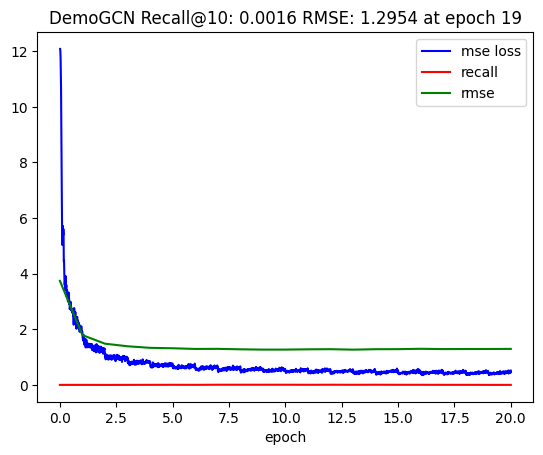

DemoGCN Recall@10: 0.0016 RMSE: 1.2954 at epoch 19


In [10]:
from gcn.train import evaluate_ranking, evaluate_rating
from gcn.visualize import Animator
ani = Animator()
num_epochs = 20
topk = 10
train_epoch_perc = []
train_loss = []
epoch_list = []
rmse_list = []
recall_list = []

with torch.no_grad():
    recall = evaluate_ranking(
        model,
        test_candidates,
        train_candidates,
        num_users,
        num_items,
        top_k = topk
    )
    recall_list.append(recall)
    rmse = evaluate_rating(
        model,
        users_test, 
        items_test, 
        ratings_test
    )
    rmse_list.append(rmse)
    epoch_list.append(0)

for epoch in range(num_epochs):
    for batch, values in enumerate(train_loader):
        users, items, ratings = values[0].to(device), values[1].to(device), values[2].to(device)
        # Forward pass
        scores = model(users, items)
        loss = loss_fn(scores, ratings.float())
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # if batch % 64 == 0:
        train_epoch_perc.append((batch+1)/ len(train_loader) + epoch)
        train_loss.append(loss.item())
        print(f'step:{batch+1}/{len(train_loader)} epoch:{epoch}/{num_epochs} loss:{train_loss[-1]}')


    with torch.no_grad():
        recall = evaluate_ranking(
            model,
            test_candidates,
            train_candidates,
            num_users,
            num_items,
            top_k = topk
        )
        recall_list.append(recall)
        rmse = evaluate_rating(
            model,
            users_test, 
            items_test, 
            ratings_test
        )
        rmse_list.append(rmse)
        epoch_list.append(epoch+1)


    ani.clear()
    ani.ax.plot(train_epoch_perc, train_loss, color='b', label='mse loss')
    ani.ax.plot(epoch_list, recall_list, color='r', label='recall')
    ani.ax.plot(epoch_list, rmse_list, color='g', label='rmse')
    ani.ax.set_xlabel('epoch')
    ani.ax.legend()
    ani.ax.set_title(f'DemoGCN Recall@{topk}: {recall_list[-1]:.4f} RMSE: {rmse_list[-1]:.4f} at epoch {epoch}')
    ani.render()

    print(f'DemoGCN Recall@{topk}: {recall_list[-1]:.4f} RMSE: {rmse_list[-1]:.4f} at epoch {epoch}')

ani.close()

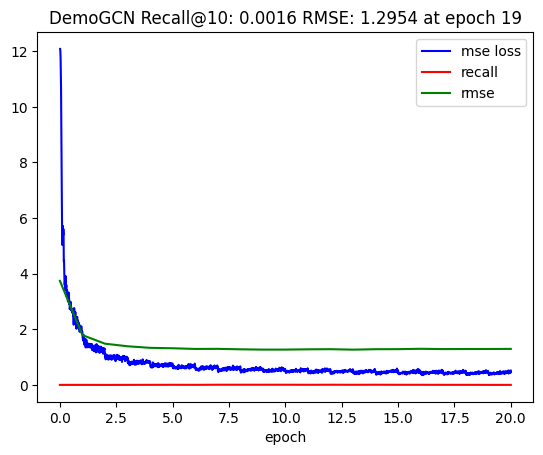

In [11]:
import matplotlib.pyplot as plt
plt.plot(train_epoch_perc, train_loss, color='b', label='mse loss')
plt.plot(epoch_list, recall_list, color='r', label='recall')
plt.plot(epoch_list, rmse_list, color='g', label='rmse')
plt.xlabel("epoch")
plt.legend()
plt.title(f'DemoGCN Recall@{topk}: {recall_list[-1]:.4f} RMSE: {rmse_list[-1]:.4f} at epoch {epoch}')
plt.show()

In [12]:
recall_list

[0.001639344262295082,
 0.001639344262295082,
 0.0,
 0.001639344262295082,
 0.003278688524590164,
 0.004918032786885246,
 0.003278688524590164,
 0.006557377049180328,
 0.006557377049180328,
 0.006557377049180328,
 0.006557377049180328,
 0.004918032786885246,
 0.006557377049180328,
 0.004918032786885246,
 0.006557377049180328,
 0.004918032786885246,
 0.004918032786885246,
 0.003278688524590164,
 0.003278688524590164,
 0.001639344262295082,
 0.001639344262295082]

In [13]:
rmse_list

[3.741561295711381,
 1.7904935885103934,
 1.4829459288109934,
 1.3899196164469443,
 1.3334285086200566,
 1.3186350442400927,
 1.2940347662180605,
 1.2970141600436595,
 1.2808049522255318,
 1.2698083663146895,
 1.2706729391636362,
 1.2799435444392067,
 1.2846219885734116,
 1.2684423383689567,
 1.283997915189007,
 1.2864693192027077,
 1.2992203428587838,
 1.288805803113857,
 1.2907489264522731,
 1.2925381130597884,
 1.2954170580585551]

In [14]:
# max(recall_list), min(rmse_list) 
print(f'DemoGCN Max Recall@{topk}: {max(recall_list):.4f} at epoch {recall_list.index(max(recall_list))}')
print(f'DemoGCN Min RMSE: {min(rmse_list):.4f} at epoch {rmse_list.index(min(rmse_list))}')

DemoGCN Max Recall@10: 0.0066 at epoch 7
DemoGCN Min RMSE: 1.2684 at epoch 13
